## Contents
- [Data Importing](#Data-Importing)
- [Classification metrics](#Classification-metrics)
- [Vectorizer Selection via GridSeachCV](#Vectorizer-Selection-via-GridSeachCV)
- [MultinomialNB and Hyperparameter tuning](#MultinomialNB-and-Hyperparameter-tuning)
- [Logistic Regression Modelling and Hyperparameter tuning](#Logistic-Regression-Modelling-and-Hyperparameter-tuning)
- [Analysis on top few features by logreg and MultinomialNB](#Analysis-on-top-few-features-by-logreg-and-MultinomialNB)
- [Random Forest Classifier](#Random-Forest-Classifier)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

In [2]:
import pandas as pd
import requests
import string
string.punctuation
import re
import nltk
from nltk.stem import WordNetLemmatizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import contractions

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, \
    plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from transformers import pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import word_tokenize   
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.dates as mdate
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

import gensim
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec


from sklearn.model_selection import(
    cross_val_score,
    train_test_split,
    GridSearchCV
)

from sklearn.preprocessing import (
    StandardScaler,
    PolynomialFeatures
)
from datetime import timezone
import datetime

pd.set_option('display.max_colwidth', None)

## Data importing

In [3]:
df = pd.read_csv('../Data/df.csv')
df.drop(columns = 'Unnamed: 0', inplace = True)

Check for Null

In [4]:
df.isnull().sum()

author                   0
subreddit                0
selftext                 0
title                    0
created_utc              0
datetime                 0
link_flair_css_class     0
alltext                  0
length_text              0
wrdcount_text            0
month                    0
day                      0
clean_text               1
ttl_post                 0
user_contribute_where    0
stem_clean_text          1
lemmi_clean_text         1
dtype: int64

In [5]:
df.dropna(inplace = True)

###  Model Prep: Create `X` and `y` variables

Our features will be:
- `subreddit`
- `stem_clean_text`
- `lemmi_clean_text`

For our baseline modelling will be using lemmi_clean_text

Our target will be `subreddit`

In [6]:
X = df['lemmi_clean_text']
y = df['subreddit']

### Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Classification Metrics

Possible classification metrics that can be used how well my model perform are *Accuracy, Misclassification Rate, Sensitivity (True Positive Rate), Specificity (True Negative Rate), Precision (Positive Predictive Value), F1 Score and ROC AUC*.

For this project I will be mainly using *Accuracy* accompanied with confusion matrix to determine effectiveness of my models

For further evaluations, I will be using Specificity to choose the best model that helps gauge on how best to minimize this in order to reduce missing out identifying users potentionally having PTSD.

I will also use ROC to gave a gauge the degree of overlap between the words in post from the two subreddits. 

### Baseline Accuracy Check

In [8]:
print(f'Total post: {len(df)}')
df['subreddit'].value_counts(normalize= True)


Total post: 20228


1    0.500395
0    0.499605
Name: subreddit, dtype: float64

With 10000 post added into each class, the classes are very well balanced from both sides 

Also, from the above, we can see the ***baseline accuracy*** is at 50.1%. 
If nothing ws done for the classification model, and just to assign every post to the PTSD class, i would classify 50.1% of the post correctly. 

Therefore, any classification model designed for this data must have an accuracy higher than the ***baseline accuracy*** of 50.1%

## Vectorizer Selection via GridSeachCV

Consider two NLP vectorizers and iterate over parameters below with Logistic regression model first.
- *Count Vectorizer*
- *TF-IDF Vectorizer*

In [9]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

# to input in subreddit headers so that we can exclude it for model
headers = ['ptsd', 'anxiety','anxious', "cptsd", 'trauma','traumatized','traumas',"posttraumatic",'stress','disorder',"traumatic", 'www', 'https', 'mentalgrenade', 'com']
for head in headers:
    stopwordlist.append(head)



In [10]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: CountVectorizer - pipe1, TfidfVectorizer - pipe2

pipe1 = Pipeline([('cvec1', CountVectorizer(stop_words= stopwordlist)),
                  ('logreg1', LogisticRegression())
                 ])

pipe2 = Pipeline([('tfvec2', TfidfVectorizer(stop_words= stopwordlist)),
                  ('logreg2', LogisticRegression())
                 ])

In [11]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe1_params = {'cvec1__max_features': [1000],
                'cvec1__min_df': [0.02],
                'cvec1__max_df': [0.7],
                'cvec1__ngram_range': [(1,1), (1,2)],
                'logreg1__max_iter': [1000]
               }

pipe2_params = {'tfvec2__max_features': [1000],
                'tfvec2__min_df': [0.02],
                'tfvec2__max_df': [0.7],
                'tfvec2__ngram_range': [(1,1), (1,2)],
                'logreg2__max_iter': [1000]
               }

In [12]:
# Creating two separate GridSearchCV objects for:
# CountVectorizer and TfidfVectorizer

gs_pipe1 = GridSearchCV(pipe1, param_grid=pipe1_params, cv=5)

gs_pipe2 = GridSearchCV(pipe2, param_grid=pipe2_params, cv=5)

In [13]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec1',
                                        CountVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [14]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec2',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [15]:
# Best combination of hyperparameters suggested by GridSearchCV for CountVectorizer transformer.

gs_pipe1.best_params_

{'cvec1__max_df': 0.7,
 'cvec1__max_features': 1000,
 'cvec1__min_df': 0.02,
 'cvec1__ngram_range': (1, 1),
 'logreg1__max_iter': 1000}

In [16]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe2.best_params_

{'logreg2__max_iter': 1000,
 'tfvec2__max_df': 0.7,
 'tfvec2__max_features': 1000,
 'tfvec2__min_df': 0.02,
 'tfvec2__ngram_range': (1, 1)}

In [17]:
# Summary scores of CountVectorizer and LogisticRegression.

print("CountVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe1.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe1.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe1.score(X_test, y_test), 3)}")

CountVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.801

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.826
Testing corpus accuracy = 0.803


In [18]:
# Summary scores of TfidfVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe2.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe2.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe2.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.809

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.83
Testing corpus accuracy = 0.81


In [19]:
# Creacting a summary dataframe.

summary_df = pd.DataFrame(columns=[
    'iteration',
    'transformer_estimator', 
    'GS_best_params', 
    'GS_best_score', 
    'train_accuracy', 
    'test_accuracy'
])

In [20]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[1] = [
    'Baseline',
    'CountVec | LogisticRegression',
    str(gs_pipe1.best_params_),
    round(gs_pipe1.best_score_, 3),
    round(gs_pipe1.score(X_train, y_train), 3),
    round(gs_pipe1.score(X_test, y_test), 3)
]

summary_df.loc[2] = [
    'Baseline',
    'TfidfVec | LogisticRegression',
    str(gs_pipe2.best_params_),
    round(gs_pipe2.best_score_, 3),
    round(gs_pipe2.score(X_train, y_train), 3),
    round(gs_pipe2.score(X_test, y_test), 3)
]

In [21]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810


From the summary table, we can infer that the best combination of transformer hyperparameters to be 
- *max_features* = 500
- *min_df* = 0.05 
- *max_df* = 0.8 
- ngram_range=(1,2)	- for *tfidfVectorizer*

Judging solely on the accuracy scores, using **CountVectorizer** has very good accuracy on the training but did poorly on the testing corpus. This implies that this model is **overfitting on the training corpus**. 

On the other, using **TfidfVectorizer** transformer has better accuracy fir GSCV best score, and lesser delta between the train and test accuracy scores, suggesting that the **model may not be as overfitted than *CountVectorizer***

Therefore, I will use *TfidfVectorizer* for further classification model.



## Hyper-parameter tuning

### MultinomialNB Classifier

There are 3 common types of Naive Bayes models: *Bernoulli Naive Bayes*, *Multinomial Naive Bayes*, and *Gaussian Naive Bayes*.

- [Bernoulli Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): when we have 0/1 variables.
- [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): when our variables are positive integers.
- [Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB): when our features are Normally distributed.

We will be using ***MultinomialNB*** as it consideres a feature vector with all the individual words in a all post where a given term represent the number of times it appears. 

In [22]:
# create pipe3 for transformer: TfidfVectorizer and estimator using MultinomialNB

pipe3 = Pipeline([('tfvec', TfidfVectorizer(stop_words= stopwordlist)),
                  ('nb', MultinomialNB())
                 ])

In [23]:
# # creating parameters for GridSearch SV using hyperparameters as shown below 
# pipe3_params = {'tfvec__max_features': np.linspace(3500,3600,10, dtype = int),
#                 'tfvec__min_df': [0.0001,0.0002,0.0003],
#                 'tfvec__max_df': [0.3],
#                 'tfvec__ngram_range': [(1,1)],
#                 'nb__alpha' : [1.0e-10],
# }

In [24]:
# creating parameters for GridSearch SV using hyperparameters as shown below 
pipe3_params = {'tfvec__max_features': [3555],
                'tfvec__min_df': [0.0002],
                'tfvec__max_df': [0.3],
                'tfvec__ngram_range': [(1,1)],
                'nb__alpha' : [1.0e-10],
}

In [25]:
# Creatingg GridSeachCV using pipeline: pipe3 and params_grid:  pipe3_params

gs_pipe3 = GridSearchCV(pipe3, param_grid=pipe3_params, cv=5,n_jobs=-1)

In [26]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
 

In [27]:
# Get best parameters using MultinomialNB and TfidfVectorizer

gs_pipe3.best_params_

{'nb__alpha': 1e-10,
 'tfvec__max_df': 0.3,
 'tfvec__max_features': 3555,
 'tfvec__min_df': 0.0002,
 'tfvec__ngram_range': (1, 1)}

In [28]:
# Summary scores of TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe3.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe3.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe3.score(X_test, y_test), 3)}")

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.828

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.854
Testing corpus accuracy = 0.827


In [29]:
# adding summary 

summary_df.loc[3] = [
    'Hyperparameter Tuned',
    'TfidfVec | MultinomialNB',
    str(gs_pipe3.best_params_),
    round(gs_pipe3.best_score_, 3),
    round(gs_pipe3.score(X_train, y_train), 3),
    round(gs_pipe3.score(X_test, y_test), 3)
]

In [30]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3555, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827


From the above table, we can see that Multinomial has overall better scores than the Log Reg. The model is relatively overfitted as well. Lets breakdown to see what are the most impactful words that distinguishes between users in r/PTSD and those who arent. 

### Logistic Regression Modelling

In [31]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: CountVectorizer - pipe1, TfidfVectorizer - pipe2

pipe4 = Pipeline([('tfvec4', TfidfVectorizer(stop_words= stopwordlist)),
                  ('logreg4', LogisticRegression())
                 ])

In [32]:
# <!-- # Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

# pipe4_params = {'tfvec4__max_features': [9000,9500,10000],
#                m 'tfvec4__min_df': [0],
#                 'tfvec4__max_df':np.linspace(0.22,0.225,10),
#                 'tfvec4__ngram_range': [(1,1)],
#                 'logreg4__max_iter': [1000]
#                } -->

In [33]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe4_params = {'tfvec4__max_features': [9500],
                'tfvec4__min_df': [0],
                'tfvec4__max_df':[0.225],
                'tfvec4__ngram_range': [(1,1)],
                'logreg4__max_iter': [1000]
               }

In [34]:
# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and Logistic Regression with Hyper-parameter tuning

gs_pipe4 = GridSearchCV(pipe4, param_grid=pipe4_params, cv=5)

In [35]:
# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec4',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [36]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe4.best_params_

{'logreg4__max_iter': 1000,
 'tfvec4__max_df': 0.225,
 'tfvec4__max_features': 9500,
 'tfvec4__min_df': 0,
 'tfvec4__ngram_range': (1, 1)}

In [37]:
# Summary scores of CountVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe4.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe4.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe4.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.845

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.897
Testing corpus accuracy = 0.844


TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.85

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.901
Testing corpus accuracy = 0.849

In [38]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[4] = [
    'Hyperparameter Tuned',
    'TfidfVec | LogisticRegression',
    str(gs_pipe4.best_params_),
    round(gs_pipe4.best_score_, 3),
    round(gs_pipe4.score(X_train, y_train), 3),
    round(gs_pipe4.score(X_test, y_test), 3)
]

In [39]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3555, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.225, 'tfvec4__max_features': 9500, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.897,0.844


The MultinomialNB has the highest scores, with slight overfit to test accuracy scores. 
However, I did notice that the Logistic Regression after hyperparameter tuning, it was able to pick up ngrams with range of 2 as a best parameter. 

### Random Forest Classifier

In [40]:
# Creating Pipeline with:
# Estimator: Random Forest Classifier
# Transformer: TfidfVectorizer - pipe5

pipe5 = Pipeline([('tfvec5', TfidfVectorizer(stop_words= stopwordlist)),
                  ('RanForest', RandomForestClassifier())
                 ])

In [41]:
# # Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

# pipe5_params = {'tfvec5__max_features': [9000],
#                 'tfvec5__min_df': [0],
#                 'tfvec5__max_df': [0.7,0.75,0.8],
#                 'tfvec5__ngram_range': [(1,1)],
#                 'RanForest__n_estimators': [300],
#                 'RanForest__max_depth': [None],
#                 'RanForest__max_features': ['sqrt']
#                }

In [42]:
# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe5_params = {'tfvec5__max_features': [9000],
                'tfvec5__min_df': [0],
                'tfvec5__max_df': [0.8],
                'tfvec5__ngram_range': [(1,1)],
                'RanForest__n_estimators': [300],
                'RanForest__max_depth': [None],
                'RanForest__max_features': ['sqrt']
               }

In [43]:
# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and RandomForestClassifier with Hyper-parameter tuning

gs_pipe5 = GridSearchCV(pipe5, param_grid=pipe5_params, cv=5, n_jobs= -1)

In [44]:
# Fitting GridSearchCV with TfidfVectorizer transformer on X_train and y_train.

gs_pipe5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfvec5',
                                        TfidfVectorizer(stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',


In [45]:
# Best combination of hyperparameters suggested by GridSearchCV for TfidfVectorizer transformer.

gs_pipe5.best_params_

{'RanForest__max_depth': None,
 'RanForest__max_features': 'sqrt',
 'RanForest__n_estimators': 300,
 'tfvec5__max_df': 0.8,
 'tfvec5__max_features': 9000,
 'tfvec5__min_df': 0,
 'tfvec5__ngram_range': (1, 1)}

In [46]:
# Summary scores of TfidfVectorizer and RandomForestClassifier.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe5.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe5.score(X_train, y_train), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe5.score(X_test, y_test), 3)}")

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.823

Using GridSearchCV best params suggested,
Training corpus accuracy = 1.0
Testing corpus accuracy = 0.827


In [47]:
# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[5] = [
    'Hyperparameter Tuned',
    'TfidfVec | RandomForest',
    str(gs_pipe5.best_params_),
    round(gs_pipe5.best_score_, 3),
    round(gs_pipe5.score(X_train, y_train), 3),
    round(gs_pipe5.score(X_test, y_test), 3)
]

In [48]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3555, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.225, 'tfvec4__max_features': 9500, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.897,0.844
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.8, 'tfvec5__max_features': 9000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.823,1.000,0.827


We can see clear overfitting from the RandomForest Classifier from the training set which scored at 0.999 vs test data of 0.81. This suggest that the model will be unfit to generalise to unseen data. 

## Error Analysis

### Analysis on top few features

Comparison between Logistic Regression, MultinomialNB and RandomForest

Features were selected by retrieving feature importance by calculating:
- Coefficients from Logistic regression
- Relative difference of log probability from MultinomialNB
- Mean decrease in impurity from RandomForest

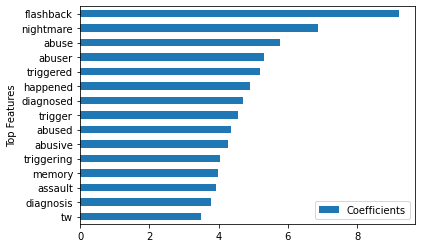

In [49]:
df_logreg = pd.DataFrame([[x,y] for x,y in zip(gs_pipe2.best_estimator_[0].get_feature_names_out(), (gs_pipe2.best_estimator_[1].coef_).tolist()[0])])
df_logreg.rename(columns= {0: 'Features', 1: 'Coefficients'}, inplace = True)
df_logreg.sort_values(by = 'Coefficients', ascending = False).head(15)


df_plot_logreg_top = pd.DataFrame(
        {
        'Coefficients': df_logreg.sort_values(by = 'Coefficients', ascending = False).head(15)['Coefficients'].tolist(),
        'Top Features': df_logreg.sort_values(by = 'Coefficients', ascending = False).head(15)['Features'].tolist()
})


df_plot_logreg_top.sort_values(by = 'Coefficients', ascending = True).plot.barh(x = 'Top Features', y='Coefficients');



In [50]:
gs_pipe3.best_estimator_[0].get_feature_names_out()

array(['ab', 'abandoned', 'abandonment', ..., 'zone', 'zoning', 'zoom'],
      dtype=object)

In [51]:
gs_pipe3.best_estimator_[1].feature_log_prob_[0,0]

-10.572373668497137

In [52]:
gs_pipe3.best_estimator_[1].feature_log_prob_[1,0]

-9.417041177300522

In [53]:
gs_pipe3.best_estimator_[1].feature_log_prob_[1, :] - gs_pipe3.best_estimator_[1].feature_log_prob_[0, :]

array([ 1.15533249,  1.50594691,  1.43264377, ..., -0.62336898,
        0.53052085, -1.03481485])

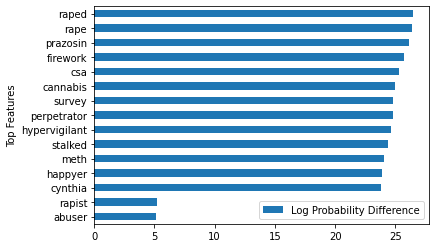

In [54]:
delta = gs_pipe3.best_estimator_[1].feature_log_prob_[1, :] - gs_pipe3.best_estimator_[1].feature_log_prob_[0, :]

df_multinomial = pd.DataFrame([[x,y] for x,y in zip(gs_pipe3.best_estimator_[0].get_feature_names_out(),(delta))])
df_multinomial.rename(columns= {0: 'Features', 1: 'log_prob_diff'}, inplace = True)
df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(15)

df_plot_multi_top = pd.DataFrame(
        {
        'Log Probability Difference': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(15)['log_prob_diff'].tolist(),
        'Top Features': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).head(15)['Features'].tolist()
})


df_plot_multi_top.sort_values(by = 'Log Probability Difference', ascending = True).plot.barh(x = 'Top Features', y='Log Probability Difference');

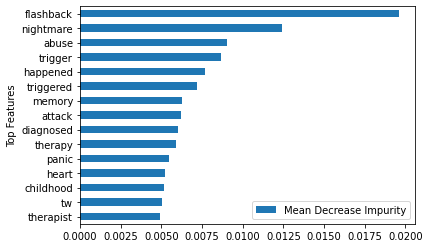

In [55]:
forest_feat_importance = pd.DataFrame(gs_pipe5.best_estimator_[1].feature_importances_, index = gs_pipe5.best_estimator_[0].get_feature_names_out()).sort_values(by = 0, ascending = False).head(15)
forest_feat_importance.columns = ['mean_decrease_impurity']

forest_feat_importance = forest_feat_importance.reset_index()
forest_feat_importance.columns = ['Features', 'mean_decrease_impurity']


df_plot_forest_top = pd.DataFrame(
        {
        'Mean Decrease Impurity': forest_feat_importance['mean_decrease_impurity'].tolist(),
        'Top Features': forest_feat_importance['Features'].tolist()
})


df_plot_forest_top.sort_values(by = 'Mean Decrease Impurity', ascending = True).plot.barh(x = 'Top Features', y='Mean Decrease Impurity');

**Comments on top few features**
- For logistic regression model, the top few features like 'flashbacks', 'nightmares', 'triggers' can serve as ***true symptoms of users suffering from PTSD***. Based on ([*source*](https://www.psychologytoday.com/us/conditions/post-traumatic-stress-disorder)), patients suffering from PTSD then to have those stated features. 

- Although it contains some words like 'abuse' that might describe ***causes of PTSD***, I believe when looking at the top few features from MultinomialNB, I can find more words that describes the ***causes AND triggers of PTSD*** more like 'rape', 'firework', 'gunshot', 'csa' which stands for childhood sexual abuse, 'repressed', 'stalked'.

- RandomForest has similar features ranked the same way as the Logistic Regression.  

- Overall by far, aligned with the accuracy score, I would conclude that MultinomialNB is more superior in getting defining words that may classifiy people with PTSD more. 

In [56]:
df.loc[df['lemmi_clean_text'].str.contains('firework'), 'lemmi_clean_text'][0:3]

35                                                                                                                                                                                                                                    anyone else feel sound hit body awful hate freaking firework
47      last night bad asking neighbor heard anything could sworn heard gun shot maybe firework nothing ordinary live country maybe people hunting bed started shaking though kept seeing dark people figure triggered feel drained crap sleep getting day like nothing happened want control vent
1646                                                                                                                                                                                                     extremely scared firework past abuse tonight firework show distract firework show tonight
Name: lemmi_clean_text, dtype: object

In [57]:
df[df['lemmi_clean_text'].str.contains('firework')].groupby('month').count()[['author']]

,author
month,
1,7
2,3
5,1
6,7
7,33
8,5
9,4
10,3
11,5


***Firework Identified***

Found Fireworks seem to be interesting, upon investigating main dataset, the word mainly coming from the text and the title as well, explaining they have triggers likely due to firework loud noises. 

The fact that it was highlighted as a main feature, suggest that it might be severe more with users from r/PTSD. True enough, based on ([*source*](https://www.insider.com/how-fireworks-affect-you-from-increased-anxiety-and-memory-problems-2020-7#:~:text=Repetitive%20fireworks%20launched%20at%20night,can%20weaken%20your%20immune%20system.)), people with past trauma related to sound are impacted significantly worse by loud explosion of fireworks, causing reminiscent of threat and may have activated the brain's threat detector. 

Linking back to the EDA on post, we did see spikes on July 2021.Based on ([*source*](https://wgntv.com/news/fireworks-retailer-warns-of-july-4-shortage-here-are-the-states-where-its-legal-to-stock-up/)), there is seasonal fireworks on every 4th of July across many states in the US. Although we cant assume most users from the subreddits are from US, but it is room for exploration, to deep dive into the location and firework activities. 



### Analysis on bottom few features

Comparison between Logistic Regression, MultinomialNB and RandomForest

Features were selected by retrieving feature importance by calculating:
- Coefficients from Logistic regression
- Relative difference of log probability from MultinomialNB
- Mean decrease in impurity from RandomForest

In [58]:
df_logreg.sort_values(by = 'Coefficients', ascending = False).tail(15)['Features'].tolist()

['health',
 'driving',
 'breath',
 'fear',
 'stressed',
 'mg',
 'medication',
 'attack',
 'worried',
 'prescribed',
 'heart',
 'worry',
 'chest',
 'stomach',
 'social']

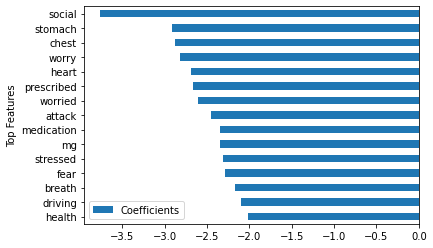

In [59]:
df_logreg = pd.DataFrame([[x,y] for x,y in zip(gs_pipe2.best_estimator_[0].get_feature_names_out(), (gs_pipe2.best_estimator_[1].coef_).tolist()[0])])
df_logreg.rename(columns= {0: 'Features', 1: 'Coefficients'}, inplace = True)
df_logreg.sort_values(by = 'Coefficients', ascending = False).tail(15)

index = df_logreg.sort_values(by = 'Coefficients', ascending = False).tail(15)['Features'].tolist()
coef = df_logreg.sort_values(by = 'Coefficients', ascending = False).tail(15)['Coefficients'].tolist()

df_plot_logreg = pd.DataFrame({'Coefficients': coef,'Top Features': index})
                        
df_plot_logreg.plot.barh(x = 'Top Features', y='Coefficients');


Words like `Anxious`, `worry`, `fear`, are most commonly used to identify as users from r/Anxiety. 

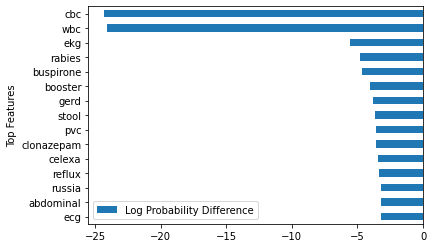

In [60]:
delta = gs_pipe3.best_estimator_[1].feature_log_prob_[1, :] - gs_pipe3.best_estimator_[1].feature_log_prob_[0, :]

df_multinomial = pd.DataFrame([[x,y] for x,y in zip(gs_pipe3.best_estimator_[0].get_feature_names_out(),(delta))])
df_multinomial.rename(columns= {0: 'Features', 1: 'log_prob_diff'}, inplace = True)
df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).tail(15)

df_plot_multi = pd.DataFrame({
    'Log Probability Difference': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).tail(15)['log_prob_diff'].tolist(),
    'Top Features': df_multinomial.sort_values(by = 'log_prob_diff', ascending = False).tail(15)['Features'].tolist()}
)
                        
df_plot_multi.plot.barh(x = 'Top Features', y='Log Probability Difference');

Words such as `CBC - Complete Blood Count`, `wbc - White blood cells` and `ekg` have the most predictive power to skew predictions towards r/Anxiety.

This indicates that most people having Anxiety will go for treatments and medications and often check for vital signs such as `cbc` and `wbc`. Based on ([*source*](https://pubmed.ncbi.nlm.nih.gov/28697416/)), people with anxiety tend to have increase `WBC` after measuring and evaluated their `CBC`. 

### Confusion matrix

Keeping in mind of minimising False negatives to boost sensitivity, we will use only MultinomialNB with the best params attained above for further error analysis 

We will look at the following 
1) False Negatives 
2) False Positive

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


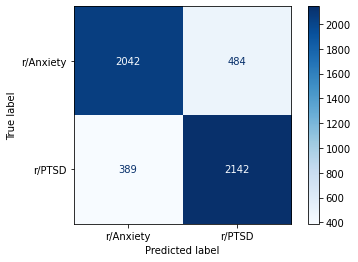

In [61]:
# Generate predictions.
preds = gs_pipe3.predict(X_test)

# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

# Plot Confusion matrix
plot_confusion_matrix(gs_pipe3, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['r/Anxiety', 'r/PTSD']);                 

### Analysis of Misclassified Posts

We will be having two approaches 
1) Parallel comparison 
2) Analyse False Positive/negative classes for counts/weights of each word

In [62]:
# create a dataframe to contain the posts, actual reddit and predicted reddit

y_test_pred_df = pd.DataFrame()
y_test_pred_df['index'] = y_test.index
y_test_pred_df['y'] = y_test.values
y_test_pred_df['y_pred'] = preds
y_test_pred_df = y_test_pred_df.merge(df.reset_index(), on = 'index')

y_test_pred_df = y_test_pred_df[['author','index','y','y_pred','title','selftext','lemmi_clean_text','month','user_contribute_where']]

In [63]:
error_df = y_test_pred_df[((y_test_pred_df['y'] == 1) & (y_test_pred_df['y_pred'] == 0)) | ((y_test_pred_df['y'] == 0) & (y_test_pred_df['y_pred'] == 1))]

#### Parallel comparison

In [64]:
## False Negative dataframe

false_neg = error_df[(error_df['y_pred'] == 0) & (error_df['user_contribute_where'] == 'both')]
false_neg[['title','lemmi_clean_text','y','y_pred']].head(5)

,title,lemmi_clean_text,y,y_pred
391,Can’t seem to relax,past - year state constant mental distress cannot seem relax everything bother frustrates keep intrusive thought get angry sad get overwhelming get better started address year ago le gotten slightly better maybe point would like also dealing w think dp dr year exhausted brain torturing cannot seem relax,1,0
431,talking to someone in my head?,hi quite feel really weird someone really trust everything always alone always talking head like whole story feeling often kind worried normal talking someone head,1,0
970,I Stole Money to Eat,know even fall since medication behaving weirdly went depression week ago unemployment ran read big red print front page submitting proof self-employed filed appeal submitted paperwork depression tore life apart kind since money tight bf rock pay everything well mean like end borrow parent sometimes really trying together going fine money got cut three week pay stuff towards end fighting lobster breaking body try bring much money possible u save get place right got spot almost able save happened frustrated good reason handle pressure well neither kind explosive trying live co-create x b anyways maine away everyone everything know fight found gift card room broken three dollar name decided use night like midnight ended talking getting back together next morning yesterday woke unemployment account paid back lent week feel guilty taking money card feel like cannot even tell hate rest eternity never steal honest kind furious heartbroken hungry starving really trying fast want ask money well like feel guilty also feel worried super happy paying back getting unemployment past girlfriend stolen ton said would pay back never etc stolen whole life reason come clean like got back together even hour yet know stole money eat,1,0
1238,losing weight because of ptsd,anyone else experience weight loss right cm kg eating food make throw stressed appetite completely gone anyone advice losing weight,1,0
1277,Work problems,let go job third month wednesday panic attack suicidal primary concern phone time coworker comanager calling texted let coworker know medical emergency would able go work day told coworker would reach bos hr done talking doctor text message eventually contacted hr hour later technically yes show let know happened thursday friday today hospital medical documentation every day except wednesday spoke hr today let go call show wednesday cut loss try fight hr nice understanding good relationship following order general manager depression pretty well last week lot going trigger working work problem,1,0


In [65]:
potential_anomaly = false_neg[false_neg['user_contribute_where'] == 'both']

In [66]:
List_of_words = pd.DataFrame(potential_anomaly['lemmi_clean_text'].apply(word_tokenize).sum()).reset_index()
List_of_words['index'] = 1
List_of_words.columns = ['Counts', 'Features']

List_of_words.groupby('Features').sum().sort_values(by = 'Counts',ascending=False)

,Counts
Features,
like,16
feel,15
day,8
going,7
know,7
...,...
gift,1
gi,1
general,1


In [67]:
# we create dataframe that contains log prob diff
filter_false_neg = List_of_words.merge(df_multinomial , on = 'Features', how ='inner')
total_count = filter_false_neg['Counts'].sum()
filter_false_neg['weight'] = filter_false_neg['Counts'].apply(lambda x: x/total_count)


def multiply(col):
    weight = col[0]
    log = col[1]
    return weight * log


filter_false_neg['weight'] = filter_false_neg[['weight','log_prob_diff']].apply(lambda x: multiply(x), axis =1)
filter_false_neg['weight']

weight = filter_false_neg['weight'].sum()
print(f'Weightage of anomoly: {weight}')

filter_false_neg.sort_values(by = 'weight', ascending=True).head(20)

Weightage of anomoly: -0.09145174568449808


,Counts,Features,log_prob_diff,weight
449,1,peak,-2.109752,-0.003815
396,1,overthinking,-2.000643,-0.003618
472,1,stutter,-1.998686,-0.003614
124,1,tight,-1.994901,-0.003607
506,1,ssri,-1.979013,-0.003579
404,1,ate,-1.524965,-0.002758
204,1,pressure,-1.382554,-0.002500
552,1,sensation,-1.317476,-0.002382
536,1,test,-1.317261,-0.002382
257,1,hungry,-1.282566,-0.002319


For class to be misclassified as `FALSE NEGATIVE`, its coefficients need to be `-ve`. Hence, the calculatd net weight of the users from both subreddits, contributed a -ve log prob towards r/Anxiety. 

I would want to remove those words that have `LOW NEGATIVE COEFFICIENTS` so as to only leave out clearly defining words to separate both subreddits

Common words such as 

In [68]:
remove_set = set(filter_false_neg[(filter_false_neg['weight'] <= 0) & (filter_false_neg['weight'] > -0.0005)]['Features'])

In [69]:
# Get words in false Negative

unique_in_false_neg = set(false_neg['lemmi_clean_text'].apply(word_tokenize).sum())

In [70]:
## False Negative dataframe

false_pos = error_df[error_df['y_pred'] == 1]

In [71]:
potential_anomaly = false_pos[false_pos['user_contribute_where'] == 'both']

In [72]:
test = pd.DataFrame(potential_anomaly['lemmi_clean_text'].apply(word_tokenize).sum()).reset_index()
test['index'] = 1
test.columns = ['Counts', 'Features']
test = test.groupby('Features').sum().sort_values(by = 'Counts',ascending=False)

test

,Counts
Features,
would,10
year,7
can,7
time,7
not,7
...,...
gesture,1
gave,1
gaslit,1


In [73]:
# we create dataframe that contains log prob diff
filter_false_pos = test.merge(df_multinomial , on = 'Features', how ='inner')
total_count = filter_false_pos['Counts'].sum()
filter_false_pos['weight'] = filter_false_pos['Counts'].apply(lambda x: x/total_count)


def multiply(col):
    weight = col[0]
    log = col[1]
    return weight * log


filter_false_pos['weight'] = filter_false_pos[['weight','log_prob_diff']].apply(lambda x: multiply(x), axis =1)
filter_false_pos['weight']

weight = filter_false_pos['weight'].sum()
print(f'Weightage of anomoly: {weight}')

filter_false_pos.sort_values(by = 'weight', ascending=False).head(10)

Weightage of anomoly: 0.11459151880716066


,Features,Counts,log_prob_diff,weight
15,abused,3,3.526218,0.025552
8,abusive,4,2.363389,0.022835
228,assault,1,4.545069,0.010978
28,happened,3,1.158015,0.008391
64,vivid,2,1.514937,0.007319
215,abuse,1,2.971452,0.007177
4,suicidal,4,0.726792,0.007022
38,psychotic,2,1.307782,0.006318
214,abusing,1,2.339172,0.005650
43,dream,2,1.086424,0.005248


In [74]:
remove_set2 = set(filter_false_pos[(filter_false_pos['weight'] >= 0) & (filter_false_pos['weight'] < 0.0005)]['Features'])

In [75]:
# Get words in false Positive

unique_in_false_pos = set(false_pos['lemmi_clean_text'].apply(word_tokenize).sum())

In [76]:
false_neg[false_neg['user_contribute_where'] == 'both'].shape

(12, 9)

In [77]:
false_neg.shape

(12, 9)

In [78]:
false_neg[false_neg['user_contribute_where'] == 'both']['author'].unique()

array(['_spaceguy-_-', 'asscrackhairs', 'schoolgrrl', 'Lilyflamingo1109',
       'Laurel2000SGX', 'sanpedro12', 'TakeYourVitamin', 'kyluvxo',
       'Suspicious_Tune7611'], dtype=object)

### Re-run models

Remove duplicated users to remove potential misclassifications

We filter off users that are active in both subreddits and run two models with same settings in the hyper-parameter tuning
- MultinomialNB
- Logistic Regression

In [79]:
# how many rows deleted 
before = df.shape[0]
after = df[df['user_contribute_where']  != 'both'].shape[0]
print(f'Number of rows removed: {before - after}')
print(f'Percentage data removed: {round(((after - before) / before) * 100,2)}%')

Number of rows removed: 352
Percentage data removed: -1.74%


In [80]:
X_train_filtered = df[df['user_contribute_where']  != 'both']['lemmi_clean_text']
y_train_filtered = df[df['user_contribute_where']  != 'both']['subreddit']

In [81]:
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_train_filtered, y_train_filtered, random_state=42, stratify=y_train_filtered)

#### Multinomial regression with refined dataset

In [82]:
# create pipe3 for transformer: TfidfVectorizer and estimator using MultinomialNB

pipe6 = Pipeline([('tfvec', TfidfVectorizer(stop_words= stopwordlist)),
                  ('nb', MultinomialNB())
                 ])
                 
# creating parameters for GridSearch SV using hyperparameters as shown below 
pipe6_params = {'tfvec__max_features': np.linspace(3700,3800,3, dtype = int),
                'tfvec__min_df': np.linspace(0,0.0001,5),
                'tfvec__max_df': np.linspace(0.20,0.3,5),
                'tfvec__ngram_range': [(1,1)],
                'nb__alpha' : [1.0e-10],
}

# Creatingg GridSeachCV using pipeline: pipe3 and params_grid:  pipe3_params

gs_pipe6 = GridSearchCV(pipe6, param_grid=pipe6_params, cv=5, n_jobs= -1)

# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe6.fit(X_train_filtered, y_train_filtered);

# Summary scores of TfidfVectorizer and MultinomialNB.

print("TfidfVectorizer with MultinomialNB summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe6.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe6.score(X_train_filtered, y_train_filtered), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe6.score(X_test_filtered, y_test_filtered), 3)}")

# adding summary 

summary_df.loc[6] = [
    'Refined Dataset',
    'TfidfVec | MultinomialNB',
    str(gs_pipe6.best_params_),
    round(gs_pipe6.best_score_, 3),
    round(gs_pipe6.score(X_train_filtered, y_train_filtered), 3),
    round(gs_pipe6.score(X_test_filtered, y_test_filtered), 3)
]

TfidfVectorizer with MultinomialNB summary of accuracy scores:
GridSearchCV best accuracy = 0.834

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.858
Testing corpus accuracy = 0.834


#### Logistic regression with refined dataset

In [83]:
# <!-- # Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

# pipe4_params = {'tfvec4__max_features': [9000,9500,10000],
#                m 'tfvec4__min_df': [0],
#                 'tfvec4__max_df':np.linspace(0.22,0.225,10),
#                 'tfvec4__ngram_range': [(1,1)],
#                 'logreg4__max_iter': [1000]
#                } -->

In [84]:
# Creating Pipeline with:
# Estimator: LogisticRegression (both)
# Transformer: CountVectorizer - pipe1, TfidfVectorizer - pipe2

pipe7 = Pipeline([
    ('tfvec7', TfidfVectorizer(stop_words= stopwordlist)),
    ('logreg7', LogisticRegression())
])

# Declaring fixed one-off hyperparameters max_features, min_df, max_df & ngram_range for GridSearchCV first.

pipe7_params = {'tfvec7__max_features': np.linspace(8500,9000,10, dtype = int),
                'tfvec7__min_df': np.linspace(0.0,0.00000001,5),
                'tfvec7__max_df':np.linspace(0.23,0.25,5),
                'tfvec7__ngram_range': [(1,1)],
                'logreg7__max_iter': [1000]
}

# Creating two separate GridSearchCV objects for:
# TfidfVectorizer and Logistic Regression with Hyper-parameter tuning

gs_pipe7 = GridSearchCV(pipe7, param_grid=pipe7_params, cv=5, n_jobs=-1)

# Fitting GridSearchCV with CountVectorizer transformer on X_train and y_train.

gs_pipe7.fit(X_train_filtered, y_train_filtered)

# Summary scores of CountVectorizer and LogisticRegression.

print("TfidfVectorizer with LogisticRegression summary of accuracy scores:")
print(f"GridSearchCV best accuracy = {round(gs_pipe7.best_score_, 3)}")
print("\nUsing GridSearchCV best params suggested,")
print(f"Training corpus accuracy = {round(gs_pipe7.score(X_train_filtered, y_train_filtered), 3)}")
print(f"Testing corpus accuracy = {round(gs_pipe7.score(X_test_filtered, y_test_filtered), 3)}")


# Adding the accuracy scores from above two GridSearchCV models into summary_df.

summary_df.loc[7] = [
    'Refined DataSet',
    'TfidfVec | LogisticRegression',
    str(gs_pipe7.best_params_),
    round(gs_pipe7.best_score_, 3),
    round(gs_pipe7.score(X_train_filtered, y_train_filtered), 3),
    round(gs_pipe7.score(X_test_filtered, y_test_filtered), 3)
]

TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.847

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.899
Testing corpus accuracy = 0.847


TfidfVectorizer with LogisticRegression summary of accuracy scores:
GridSearchCV best accuracy = 0.854

Using GridSearchCV best params suggested,
Training corpus accuracy = 0.905
Testing corpus accuracy = 0.848

#### Summary table Analysis

In [85]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3555, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.225, 'tfvec4__max_features': 9500, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.897,0.844
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.8, 'tfvec5__max_features': 9000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.823,1.000,0.827
6,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834
7,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.25, 'tfvec7__max_features': 8555, 'tfvec7__min_df': 0.0, 'tfvec7__ngram_range': (1, 1)}",0.847,0.899,0.847


## Production Model Selection

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


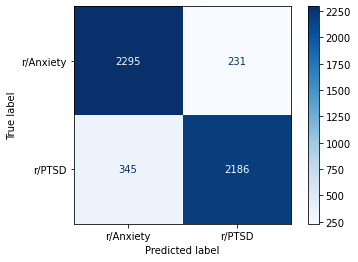

In [86]:
# Generate predictions.
preds = gs_pipe7.predict(X_test)

# Generate confusion matrix.
# Documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

confusion_matrix(y_test, # True values.
                 preds)  # Predicted values.

# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();

# Plot Confusion matrix
plot_confusion_matrix(gs_pipe7, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['r/Anxiety', 'r/PTSD']);                 

### Sensitivity of pipelines

In [87]:
# What is the test sensitivity of our model?
# By hand
list_of_gs = [gs_pipe1, gs_pipe2, gs_pipe3, gs_pipe4, gs_pipe5, gs_pipe6, gs_pipe7]


sensitivity_df = []
for gs in list_of_gs:
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
    sensitivity_df.append(tp / (tp + fn))
    print(gs.best_estimator_[1],tp / (tp + fn))

sensitivity_df= pd.DataFrame(sensitivity_df)

LogisticRegression(max_iter=1000) 0.7538522323192414
LogisticRegression(max_iter=1000) 0.772026866851047
MultinomialNB(alpha=1e-10) 0.8463058079810352
LogisticRegression(max_iter=1000) 0.8127222441722639
RandomForestClassifier(max_features='sqrt', n_estimators=300) 0.7992888186487555
MultinomialNB(alpha=1e-10) 0.8640853417621494
LogisticRegression(max_iter=1000) 0.863690241011458


In [88]:
summary_df

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy
1,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803
2,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810
3,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3555, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827
4,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.225, 'tfvec4__max_features': 9500, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.897,0.844
5,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.8, 'tfvec5__max_features': 9000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.823,1.000,0.827
6,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834
7,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.25, 'tfvec7__max_features': 8555, 'tfvec7__min_df': 0.0, 'tfvec7__ngram_range': (1, 1)}",0.847,0.899,0.847


In [89]:
summary_sensitivity = pd.merge(summary_df.reset_index(), sensitivity_df, left_index=True, right_index=True).drop(columns = 'index').rename(columns = {0:'Sensitivity'})
summary_sensitivity.sort_values(by = 'Sensitivity', ascending = False)

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy,Sensitivity
5,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834,0.864085
6,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.25, 'tfvec7__max_features': 8555, 'tfvec7__min_df': 0.0, 'tfvec7__ngram_range': (1, 1)}",0.847,0.899,0.847,0.863690
2,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3555, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827,0.846306
3,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.225, 'tfvec4__max_features': 9500, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.897,0.844,0.812722
4,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.8, 'tfvec5__max_features': 9000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.823,1.000,0.827,0.799289
1,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810,0.772027
0,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803,0.753852


### Specificity of Pipelines

In [90]:
# What is the test specificity of our model?
# By hand
list_of_gs = [gs_pipe1, gs_pipe2, gs_pipe3, gs_pipe4,gs_pipe5,gs_pipe6,gs_pipe7]


specificity_df = []
for gs in list_of_gs:
    preds = gs.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel();
    specificity_df.append(tn / (tn + fp))


specificity_df= pd.DataFrame(specificity_df)

In [91]:
summary_sensitivity = pd.merge(summary_sensitivity.reset_index(), specificity_df, left_index=True, right_index=True).drop(columns = 'index').rename(columns = {0:'Specificity'})
summary_sensitivity.sort_values(by = 'Sensitivity', ascending = False)

,iteration,transformer_estimator,GS_best_params,GS_best_score,train_accuracy,test_accuracy,Sensitivity,Specificity
5,Refined Dataset,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3700, 'tfvec__min_df': 0.0, 'tfvec__ngram_range': (1, 1)}",0.834,0.858,0.834,0.864085,0.832937
6,Refined DataSet,TfidfVec | LogisticRegression,"{'logreg7__max_iter': 1000, 'tfvec7__max_df': 0.25, 'tfvec7__max_features': 8555, 'tfvec7__min_df': 0.0, 'tfvec7__ngram_range': (1, 1)}",0.847,0.899,0.847,0.863690,0.908551
2,Hyperparameter Tuned,TfidfVec | MultinomialNB,"{'nb__alpha': 1e-10, 'tfvec__max_df': 0.3, 'tfvec__max_features': 3555, 'tfvec__min_df': 0.0002, 'tfvec__ngram_range': (1, 1)}",0.828,0.854,0.827,0.846306,0.808393
3,Hyperparameter Tuned,TfidfVec | LogisticRegression,"{'logreg4__max_iter': 1000, 'tfvec4__max_df': 0.225, 'tfvec4__max_features': 9500, 'tfvec4__min_df': 0, 'tfvec4__ngram_range': (1, 1)}",0.845,0.897,0.844,0.812722,0.874901
4,Hyperparameter Tuned,TfidfVec | RandomForest,"{'RanForest__max_depth': None, 'RanForest__max_features': 'sqrt', 'RanForest__n_estimators': 300, 'tfvec5__max_df': 0.8, 'tfvec5__max_features': 9000, 'tfvec5__min_df': 0, 'tfvec5__ngram_range': (1, 1)}",0.823,1.000,0.827,0.799289,0.854711
1,Baseline,TfidfVec | LogisticRegression,"{'logreg2__max_iter': 1000, 'tfvec2__max_df': 0.7, 'tfvec2__max_features': 1000, 'tfvec2__min_df': 0.02, 'tfvec2__ngram_range': (1, 1)}",0.809,0.830,0.810,0.772027,0.847981
0,Baseline,CountVec | LogisticRegression,"{'cvec1__max_df': 0.7, 'cvec1__max_features': 1000, 'cvec1__min_df': 0.02, 'cvec1__ngram_range': (1, 1), 'logreg1__max_iter': 1000}",0.801,0.826,0.803,0.753852,0.853127


Clearly, we will choose MultinomialNB as our production model as it has relative higher accuracy scores, with minimal overfit and very high sensivity as compared to the rest of the models 

## Receiver Operating Characteristic (ROC) Curve

C:\Users\Admin\.conda\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


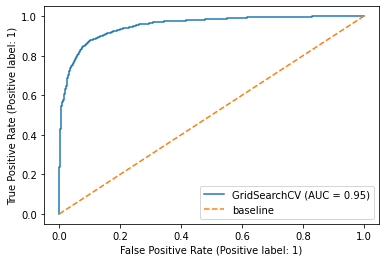

In [96]:
plot_roc_curve(gs_pipe7, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [95]:
roc_auc_score(y_test, gs_pipe6.predict_proba(X_test)[:,1])

0.9241165681730235